# Test Target Model

In [1]:
from model_predictions import deepspcas9_predictions, rule_set2_predictions, vbc_predictions
from datasets import dataset_list
import pandas as pd
import joblib
import sglearn
import gpplot
import seaborn as sns

import target_featurization as ft
from core import (point_range_plot,
                  get_model_performance)

## Import Data

In [2]:
nt_model = joblib.load('../models/RuleSet3.pkl')
target_model = joblib.load('../models/target_model.pkl')
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')

### Rename Database Columns

In [3]:
aa_seqs = aa_seqs.rename({'query': 'Transcript Base'}, axis=1)
protein_domains = protein_domains.rename({'Parent': 'Transcript Base'}, axis=1)

In [4]:
dataset_activity_list = []
for ds in dataset_list:
    if ds.endogenous:
        ds.load_data()
        ds.set_sgrnas()
        dataset_activity = ds.get_sg_df(include_group=True, include_activity=True)
        dataset_activity['dataset'] = ds.name
        design_df = ds.get_designs()
        dataset_activity = dataset_activity.merge(design_df, how='inner',
                                                  on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
        dataset_activity_list.append(dataset_activity)
dataset_activity_df = (pd.concat(dataset_activity_list)
                       .reset_index(drop=True))
dataset_activity_df = ft.add_target_columns(dataset_activity_df)  # only necessary for getting transcript bases
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,Input,Quota,Target Taxon,Target Gene ID,...,On-Target Rank,Off-Target Rank,On-Target Rank Weight,Off-Target Rank Weight,Combined Rank,Pick Order,Picking Round,Picking Notes,AA Index,Transcript Base
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017,ENSG00000111605,MAX,9606,ENSG00000111605,...,140,76,1.0,1.0,96,48.0,2.0,Previously skipped due to: Spacing Violation: ...,123,ENST00000435070
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017,ENSG00000165480,MAX,9606,ENSG00000165480,...,58,29,1.0,1.0,37,23.0,2.0,Previously skipped due to: Spacing Violation: ...,258,ENST00000314759
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017,ENSG00000021776,MAX,9606,ENSG00000021776,...,179,115,1.0,1.0,88,235.0,3.0,Previously skipped due to: Outside Target Wind...,56,ENST00000156471
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017,ENSG00000117174,MAX,9606,ENSG00000117174,...,149,62,1.0,1.0,119,74.0,2.0,Previously skipped due to: Spacing Violation: ...,291,ENST00000370574
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.825581,Aguirre2017,ENSG00000204574,MAX,9606,ENSG00000204574,...,71,3,1.0,1.0,5,2.0,1.0,None,80,ENST00000326195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25831,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,0.250000,Wang2014,ENSG00000147604,MAX,9606,ENSG00000147604,...,68,76,1.0,1.0,75,65.0,5.0,Previously skipped due to: Off-target Match Bi...,34,ENST00000352983
25832,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.808824,Wang2014,ENSG00000147604,MAX,9606,ENSG00000147604,...,47,72,1.0,1.0,67,57.0,5.0,Previously skipped due to: Off-target Match Bi...,232,ENST00000352983
25833,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,0.125000,Wang2014,ENSG00000198034,MAX,9606,ENSG00000198034,...,90,84,1.0,1.0,98,93.0,5.0,Previously skipped due to: Off-target Match Bi...,249,ENST00000316084
25834,TTTGTGTATTGCGGCAAGAA,CCAGTTTGTGTATTGCGGCAAGAAGGGTTA,GGG,RPL8,0.166667,Wang2014,ENSG00000161016,MAX,9606,ENSG00000161016,...,101,8,1.0,1.0,47,38.0,2.0,Previously skipped due to: Spacing Violation: ...,92,ENST00000262584


In [5]:
transcript_bases = list(dataset_activity_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))
conservation_df['ranked_conservation'] = (conservation_df.groupby('Transcript Base')
                                          ['conservation']
                                          .rank(pct=True))

## Get Predictions

### External Models

In [6]:
model_prediction_list = [deepspcas9_predictions,
                         rule_set2_predictions,
                         vbc_predictions]
for model_prediction in model_prediction_list:
    model_prediction.load_model_predictions()
    model_prediction.get_sgrnas()
    if model_prediction.target_col is None:
        dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                        how='left',
                                                        on=['sgRNA Sequence',
                                                            'sgRNA Context Sequence',
                                                            'PAM Sequence'])
    else:
        dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                        how='left',
                                                        left_on=['sgRNA Sequence',
                                                                 'sgRNA Context Sequence',
                                                                 'PAM Sequence',
                                                                 'sgRNA Target'],
                                                        right_on=['sgRNA Sequence',
                                                                  'sgRNA Context Sequence',
                                                                  'PAM Sequence',
                                                                  model_prediction.target_col])
    dataset_activity_df[model_prediction.name + ' train'] = (dataset_activity_df['sgRNA Sequence']
                                                             .isin(model_prediction.sgrnas))
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,Input,Quota,Target Taxon,Target Gene ID,...,DeepSpCas9,DeepSpCas9 train,Rule Set 2,Rule Set 2 train,gene,VBC score,sgRNA activity 0=bad 1=good,Bioscore 0=bad 1=good,genome,VBC score train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017,ENSG00000111605,MAX,9606,ENSG00000111605,...,25.799622,False,0.489201,False,CPSF6,0.621,0.436,0.695,hg38,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017,ENSG00000165480,MAX,9606,ENSG00000165480,...,0.784734,False,0.464962,False,SKA3,0.486,0.320,0.465,hg38,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017,ENSG00000021776,MAX,9606,ENSG00000021776,...,32.187088,False,0.525786,False,AQR,0.665,0.551,0.613,hg38,False
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017,ENSG00000117174,MAX,9606,ENSG00000117174,...,19.478521,False,0.369761,False,ZNHIT6,0.549,0.358,0.580,hg38,False
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.825581,Aguirre2017,ENSG00000204574,MAX,9606,ENSG00000204574,...,44.334572,False,0.604568,False,ABCF1,0.592,0.657,0.428,hg38,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25833,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,0.250000,Wang2014,ENSG00000147604,MAX,9606,ENSG00000147604,...,10.168873,False,0.333939,False,RPL7,0.534,0.335,0.582,hg38,False
25834,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.808824,Wang2014,ENSG00000147604,MAX,9606,ENSG00000147604,...,49.501511,False,0.489867,False,RPL7,0.565,0.549,0.516,hg38,False
25835,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,0.125000,Wang2014,ENSG00000198034,MAX,9606,ENSG00000198034,...,40.421345,False,0.445911,False,RPS4X,0.506,0.331,0.572,hg38,False
25836,TTTGTGTATTGCGGCAAGAA,CCAGTTTGTGTATTGCGGCAAGAAGGGTTA,GGG,RPL8,0.166667,Wang2014,ENSG00000161016,MAX,9606,ENSG00000161016,...,29.768770,False,0.472521,False,RPL8,0.489,0.403,0.444,hg38,False


In [7]:
model_prediction_names = [m.name for m in model_prediction_list]
dataset_activity_df[model_prediction_names].isna().sum()

DeepSpCas9       0
Rule Set 2       0
VBC score     1514
dtype: int64

### Rule Set 3

In [8]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

train_data_sgs = set()
for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()
    train_data_sgs |= set(ds.sgrnas)

X = sglearn.featurize_guides(dataset_activity_df['sgRNA Context Sequence'])
dataset_activity_df['Rule Set 3'] = nt_model.predict(X)
dataset_activity_df['Rule Set 3 train'] = dataset_activity_df['sgRNA Sequence'].isin(train_data_sgs)
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,Input,Quota,Target Taxon,Target Gene ID,...,Rule Set 2,Rule Set 2 train,gene,VBC score,sgRNA activity 0=bad 1=good,Bioscore 0=bad 1=good,genome,VBC score train,Rule Set 3,Rule Set 3 train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017,ENSG00000111605,MAX,9606,ENSG00000111605,...,0.489201,False,CPSF6,0.621,0.436,0.695,hg38,False,0.284257,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017,ENSG00000165480,MAX,9606,ENSG00000165480,...,0.464962,False,SKA3,0.486,0.320,0.465,hg38,False,0.183963,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017,ENSG00000021776,MAX,9606,ENSG00000021776,...,0.525786,False,AQR,0.665,0.551,0.613,hg38,False,0.415110,False
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017,ENSG00000117174,MAX,9606,ENSG00000117174,...,0.369761,False,ZNHIT6,0.549,0.358,0.580,hg38,False,0.158673,False
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.825581,Aguirre2017,ENSG00000204574,MAX,9606,ENSG00000204574,...,0.604568,False,ABCF1,0.592,0.657,0.428,hg38,False,0.350235,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25833,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,0.250000,Wang2014,ENSG00000147604,MAX,9606,ENSG00000147604,...,0.333939,False,RPL7,0.534,0.335,0.582,hg38,False,0.241565,True
25834,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.808824,Wang2014,ENSG00000147604,MAX,9606,ENSG00000147604,...,0.489867,False,RPL7,0.565,0.549,0.516,hg38,False,0.581885,True
25835,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,0.125000,Wang2014,ENSG00000198034,MAX,9606,ENSG00000198034,...,0.445911,False,RPS4X,0.506,0.331,0.572,hg38,False,0.421645,True
25836,TTTGTGTATTGCGGCAAGAA,CCAGTTTGTGTATTGCGGCAAGAAGGGTTA,GGG,RPL8,0.166667,Wang2014,ENSG00000161016,MAX,9606,ENSG00000161016,...,0.472521,False,RPL8,0.489,0.403,0.444,hg38,False,0.443100,True


### Rule Set 3 Target

In [9]:
target_cols = ['sgRNA Sequence', 'sgRNA Context Sequence',
               'Orientation', 'Target Cut %', 'Target Cut Length',
               'Target Transcript']  # Note don't need Transcript Base and AA Index
unique_activity = dataset_activity_df[target_cols].drop_duplicates()
target_feature_df, target_feature_cols = ft.build_target_feature_df(unique_activity,
                                                                    features=['position', 'aa',
                                                                              'domain', 'conservation'],
                                                                    aa_seq_df=aa_seqs,
                                                                    protein_domain_df=protein_domains,
                                                                    conservation_df=conservation_df)
X_target = target_feature_df[target_feature_cols]
unique_activity['Target Score'] = target_model.predict(X_target)
dataset_activity_df = (dataset_activity_df.merge(unique_activity, how='left',
                                                 on=target_cols))
dataset_activity_df['Rule Set 3 Target'] = (dataset_activity_df['Rule Set 3'] +
                                            dataset_activity_df['Target Score'])
dataset_activity_df['Rule Set 3 Target train'] = dataset_activity_df['Rule Set 3 train']

### Performance

In [10]:
score_cols = ['Rule Set 3', 'Rule Set 3 Target'] + model_prediction_names
guide_train_cols = [name + ' train' for name in score_cols]
filtered_predictions = dataset_activity_df[~dataset_activity_df[guide_train_cols].any(axis=1)].copy()
long_predictions = (filtered_predictions.melt(id_vars=['sgRNA Sequence', 'sgRNA Context Sequence',
                                                       'PAM Sequence', 'sgRNA Activity',
                                                       'sgRNA Target', 'dataset'],
                                              value_vars=score_cols,
                                              var_name='model',
                                              value_name='prediction')
                    .dropna())
predictive_performance_ci = get_model_performance(long_predictions)

100%|██████████| 1000/1000 [01:55<00:00,  8.64it/s]


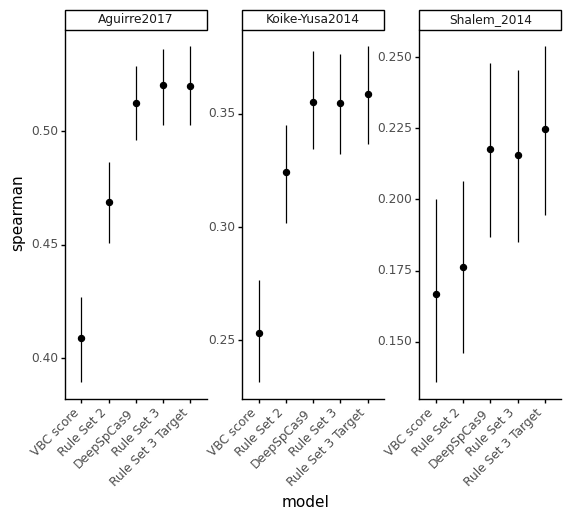

<ggplot: (8764147553865)>

In [11]:
point_range_plot(predictive_performance_ci, 'model', 'spearman',
                 'spearman_025', 'spearman_975')

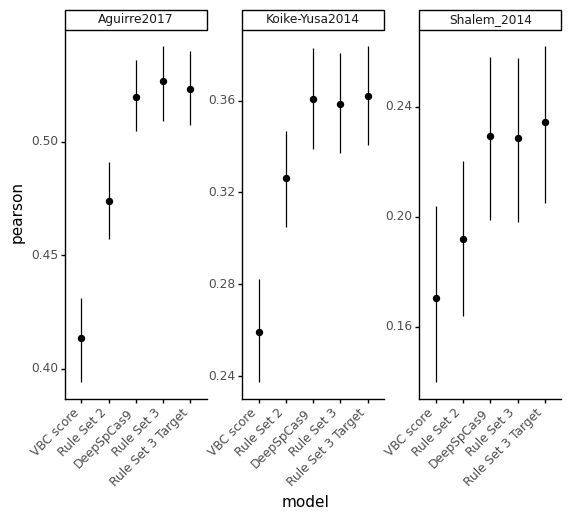

<ggplot: (8764266521796)>

In [12]:
point_range_plot(predictive_performance_ci, 'model', 'pearson',
                 'pearson_025', 'pearson_975')

## Comparison With Bioscore

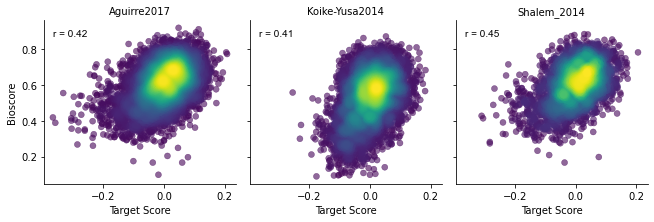

In [13]:
def scatter_density(data, x, y, **kwargs):
    gpplot.point_densityplot(data[[x, y]].dropna(), x, y, **kwargs)
    gpplot.add_correlation(data[[x, y]].dropna(), x, y)

g = sns.FacetGrid(data=filtered_predictions.rename({'Bioscore 0=bad 1=good': 'Bioscore'}, axis=1),
                  col='dataset', aspect=1)
g.map_dataframe(scatter_density, x='Target Score', y='Bioscore')
g.set_xlabels('Target Score')
g.set_ylabels('Bioscore')
g.set_titles(col_template='{col_name}')